In [1]:
import os
import torch
import math
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms

/Users/ericmonzon/mambaforge/envs/pytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dest = os.path.join("..", "data")

transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]
    )

train = CIFAR10(root=dest, train=True, download=True, transform=transform)
test = CIFAR10(root=dest, train=False, download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
train_loader = DataLoader(train, batch_size=5, shuffle=True)
val_loader = DataLoader(test, batch_size=5, shuffle=False)

In [4]:
patch_size = 4
num_channels = 3
embed_dim = 512

In [5]:
class Patchifier(nn.Module):
    """
    A class to patchify the input image.

    Parameters
    ----------
    patch_size: int
        The size of each patch.

    num_channels: int
        The number of channels in the input image.

    embed_dim: int
        The dimensions of the output embedding

    Returns
    -------
    x: torch.Tensor
        The flattened sequence of patches projected through 
        a linear transformation combined with the special CLS token.
    """

    def __init__(self, patch_size: int, num_channels: int, embed_dim: int) -> torch.Tensor:
        super(Patchifier, self).__init__()

        self.patch_size = patch_size
        self.embed_dim = embed_dim

        self.proj = nn.Conv2d(
            num_channels, embed_dim, kernel_size=patch_size, stride=patch_size
            )

        self.cls_token = nn.Parameter(torch.randn(1, 1, self.embed_dim))

    def forward(self, img):
        batch_size = img.shape[0]

        linear_projection = self.proj(img)
        linear_projection = linear_projection.flatten(-2).permute(0, 2, 1)
        
        cls_token = self.cls_token.expand(batch_size, -1, -1) 
        x = torch.cat([cls_token, linear_projection], dim=1)

        return x

In [6]:
patchifier = Patchifier(patch_size, num_channels, embed_dim)

In [7]:
img, label = next(iter(train_loader))

In [8]:
test_img = img[0]
# print(test_img.shape)

patchified = patchifier(img)

In [9]:
patchified.shape

torch.Size([5, 65, 512])

In [10]:
# (N, P, E)

class PositionEncoder(nn.Module):
    """
    The position encoder to combine a position embedding to an input sequence.

    Parameters
    ----------
    sequence_len: int
        The length of the input sequence, i.e., the number of image patches.

    embed_dim: int
        The dimension of the output embedding.

    dropout_probability: float
        The probability of dropout for the combined representation from the initial
        linear projection and positional encoding.

    Returns
    -------
    combined_embedding: torch.Tensor
        The input embedding combined with the positional embedding.
    """
    def __init__(self, sequence_len: int, embed_dim: int, dropout_probability: float) -> torch.Tensor:
        super(PositionEncoder, self).__init__()

        assert embed_dim % 2 == 0, "Ensure embedding length is even for convenience and efficiency"

        self.sequence_len = sequence_len
        self.embed_dim = embed_dim
        self.position_encoding = self.get_position_encoding()

        self.dropout = nn.Dropout(p=dropout_probability)

    def get_position_encoding(self):
        max_iter = self.embed_dim // 2
        pos = torch.arange(self.sequence_len, dtype=torch.float).unsqueeze(1)

        i = torch.arange(max_iter, dtype=torch.float)

        angle_rates = 1 / (torch.pow(10_000, (2 * i) / self.embed_dim)).unsqueeze(0)
        x = pos * angle_rates

        sin_pe = torch.sin(x)
        cos_pe = torch.cos(x)

        position_encoding = torch.zeros(self.sequence_len, self.embed_dim)
        position_encoding[:, 0::2] = sin_pe
        position_encoding[:, 1::2] = cos_pe

        return position_encoding

    def forward(self, x):
        position_encoding = self.position_encoding.unsqueeze(0)
        combined_embedding = x + position_encoding
        combined_embedding = self.dropout(combined_embedding)

        return combined_embedding

In [11]:
pe = PositionEncoder(65, 512, 0)

position_encoding = pe.get_position_encoding() 

In [12]:
combined_embedding = pe(patchified)

combined_embedding.shape

torch.Size([5, 65, 512])

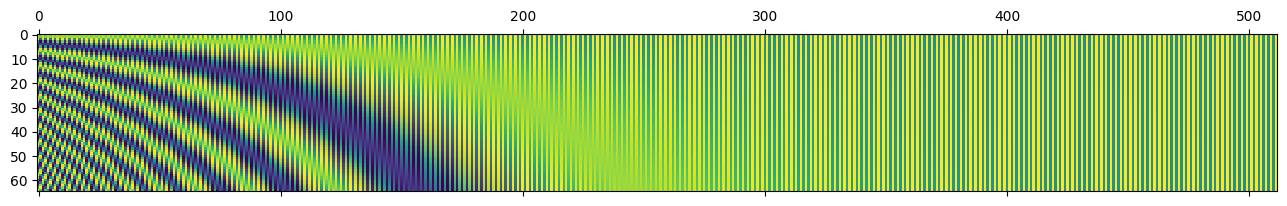

In [13]:
plt.matshow(position_encoding)

In [14]:
class MultiHeadAttention(nn.Module):
    """
    Takes in a tensor of shape (batch size, sequence length, embedding dimension) and returns the attention-informed embedding.

    Parameters
    ----------
    num_heads: int
        The number of attention heads to employ.

    sequence_length: int
        The length of the sequence, i.e., the number of image patches.

    embed_dim: int
        The output embedding dimension of the attention module.

    Returns
    -------
    final_representation: torch.Tensor
        The attention weighted representation of the model for each sequence/image patch.

    Attributes
    ----------
    head_dim: int
        The output dimension of each attention head.

    q_w: nn.Linear
        The linear transformation weights for the query vector.

    k_w: nn.Linear
        The linear transformation weights for the key vector.

    v_w: nn.Linear
        The linear transformation weights for the value vector.
    """

    def __init__(self, num_heads: int, sequence_length: int, embed_dim: int) -> torch.Tensor:
        super(MultiHeadAttention, self).__init__()
        
        assert embed_dim % num_heads == 0, "embedding dimension must be divisible by the number of attention heads"

        self.num_heads = num_heads
        self.sequence_length = sequence_length
        self.embed_dim = embed_dim
        self.head_dim = embed_dim // num_heads

        self.q_w = nn.Linear(embed_dim, embed_dim)
        self.k_w = nn.Linear(embed_dim, embed_dim)
        self.v_w = nn.Linear(embed_dim, embed_dim)
        self.fc = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        batch_size = x.shape[0]

        v = self.v_w(x).reshape(batch_size, self.sequence_length, self.num_heads, self.head_dim).transpose(1, 2)
        q = self.q_w(x).reshape(batch_size, self.sequence_length, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.k_w(x).reshape(batch_size, self.sequence_length, self.num_heads, self.head_dim).transpose(1, 2)

        attention_scores = torch.matmul(q, k.transpose(-1, -2)) / (self.head_dim ** 0.5)
        attention_weights = F.softmax(attention_scores, dim=-1)
        
        attention_embedding = torch.matmul(attention_weights, v)

        combined_heads = attention_embedding.transpose(1, 2).reshape(batch_size, self.sequence_length, self.embed_dim)

        final_representation = self.fc(combined_heads)

        return final_representation

In [15]:
multihead_attention = MultiHeadAttention(32, 65, 512)

In [16]:
multihead_attention(patchified).shape

torch.Size([5, 65, 512])

In [17]:
class MLP(nn.Sequential):
    def __init__(self, *args):
        super(MLP, self).__init__(*args)

class Encoder(nn.Sequential):
    def __init__(self, *args):
        super(Encoder, self).__init__(*args)

In [18]:
class TransformerEncoder(nn.Module):
    """
    Transformer Encoder

    Parameters
    ----------
    num_heads: int
        The number of attention heads to employ.

    sequence_length: int
        The length of the sequence, i.e., the number of image patches.

    embed_dim: int
        The output embedding dimension of the attention module.

    hidden_size: int
        The hidden size of the MLP layer.

    Returns
    -------
    z_l: torch.Tensor
        The normalized output of the final dense layer in the transformer encoder.
    """
    
    def __init__(
        self, num_heads: int, sequence_length: int, embed_dim: int, 
        hidden_size: int, dropout_probability: float
        ) -> torch.Tensor:

        super(TransformerEncoder, self).__init__()

        self.multihead_attention = MultiHeadAttention(num_heads, sequence_length, embed_dim)

        self.layer_norm = nn.LayerNorm(embed_dim)

        self.mlp = MLP(
            nn.Linear(embed_dim, hidden_size),
            nn.Dropout(p=dropout_probability),
            nn.GELU(),
            nn.Linear(hidden_size, embed_dim),
            nn.Dropout(p=dropout_probability)
        )

    def forward(self, x):
        normalized_x = self.layer_norm(x)
        z = self.multihead_attention(normalized_x) + x

        normalized_z = self.layer_norm(z)
        z = self.mlp(normalized_z) + z

        return z 

In [19]:
encoder = TransformerEncoder(32, 65, 512, 64, 0)

encoder(patchified).shape

torch.Size([5, 65, 512])

In [20]:
class VisionTransformer(nn.Module):
    """
    An implementation of the Vision Transformer from 
    `AN IMAGE IS WORTH 16X16 WORDS: TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE`.(https://arxiv.org/abs/2010.11929)

    Parameters
    ----------
    patch_size: int
        The size of each image patch.

    num_channels: int
        The number of input channels.

    embed_dim: int
        The dimension of the output embedding.

    sequence_len: int
        The length of the output sequence

    num_heads: int
        The number of self attention heads.

    num_layers: int
        The number of transformer encoder layers.
    
    hidden_size: int
        The hidden size of the MLP heads.

    dropout_probability: float
        The probability of dropouts within each dense layer, together with the 
        combined embedding from position encoding 
        (excludes the dense layers within the query, key, value projections).

    num_classes: int
        The number of classes to be predicted.

    Returns
    -------
    logits: torch.Tensor
        The raw logits of the classification head,
        projected from the final hidden state of the cls token.
    """

    def __init__(
        self, patch_size: int, num_channels: int, embed_dim: int, 
        sequence_len: int, num_heads: int, num_layers: int, hidden_size: int,
        dropout_probability: int, num_classes: int
        ) -> torch.Tensor:

        super(VisionTransformer, self).__init__()

        self.patchifier = Patchifier(patch_size, num_channels, embed_dim)
        self.position_encoder = PositionEncoder(sequence_len, embed_dim, dropout_probability)
        
        self.encoder = Encoder(*[
            TransformerEncoder(
                num_heads, sequence_len, embed_dim, hidden_size, dropout_probability
                ) for _ in range(num_layers)
                ])

        self.layer_norm = nn.LayerNorm(embed_dim)
        self.classification_head = nn.Linear(embed_dim, num_classes)
        
    def forward(self, x):
        patches = self.patchifier(x)
        x = self.position_encoder(patches)
        z = self.encoder(x)
        logits = self.classification_head(z)

        return logits

In [21]:
vit = VisionTransformer(
    patch_size=4, num_channels=3, embed_dim=768, sequence_len=65, 
    num_heads=12, num_layers=12, hidden_size=3072, dropout_probability=0,
    num_classes=len(classes)
    )

z = vit(img)

torch.Size([5, 65, 10])